# Importation des Bibliothèques  

In [37]:
import findspark
findspark.init()
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter
from pyspark.sql.functions import *

# Création d'une session de spark

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext("local")
spark = SparkSession(sc)

# Chargement de notre dataset

In [4]:
df = spark.read.format("csv").options(header="true", inferschema="true").load("Data.csv")
df.columns

['gender',
 'age',
 'diabetes',
 'hypertension',
 'stroke',
 'heart disease',
 'smoking history',
 'BMI']

In [5]:
pd.DataFrame(df.take(5),columns=df.columns)
#df.select('gender').show()

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,Female,80.0,0,0,0,1,never,25.19
1,Female,54.0,0,0,0,0,None,NaN
2,Male,28.0,0,0,0,0,never,NaN
3,Female,36.0,0,0,0,0,current,23.45
4,Male,76.0,0,1,0,1,current,20.14


# Preprocessing 

# 1) Encodage 

In [6]:
from pyspark.sql import functions as F
import random
df = df.withColumn('gender',F.when(df['gender']=='Male',1).otherwise(0))

In [7]:
df.select('gender').show()

+------+
|gender|
+------+
|     0|
|     0|
|     1|
|     0|
|     1|
|     0|
|     0|
|     0|
|     1|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     1|
|     1|
|     0|
|     0|
|     1|
+------+
only showing top 20 rows



In [8]:
df = df.withColumn('smoking history',F.when(df['smoking history']=='never',0.0).otherwise(df['smoking history']))
df = df.withColumn('smoking history',F.when(df['smoking history']=='ever',0.25).otherwise(df['smoking history']))
df = df.withColumn('smoking history',F.when(df['smoking history']=='not current',0.5).otherwise(df['smoking history']))
df = df.withColumn('smoking history',F.when(df['smoking history']=='former',0.75).otherwise(df['smoking history']))
df = df.withColumn('smoking history',F.when(df['smoking history']=='current',1.0).otherwise(df['smoking history']))


In [9]:
df.select('smoking history').show()

+---------------+
|smoking history|
+---------------+
|            0.0|
|           null|
|            0.0|
|            1.0|
|            1.0|
|            0.0|
|            0.0|
|           null|
|            0.0|
|            0.0|
|            0.0|
|           0.75|
|           0.75|
|            0.0|
|           null|
|           null|
|            0.0|
|            0.0|
|           null|
|           0.25|
+---------------+
only showing top 20 rows



# 2) Les valeurs manquantes 

In [10]:
def missing_values_table(df):    
        mis_val = df.isnull().sum()        
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        type_column = df.dtypes        
        mis_val_table = pd.concat([mis_val, mis_val_percent, type_column], axis=1)        
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2:'type_column'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [11]:
imputeDF_Pandas = df.toPandas()
missing_values_table(imputeDF_Pandas)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,type_column
smoking history,35816,35.8,object
BMI,25444,25.4,float64


In [12]:
df = df.filter(df.age >2)
imputeDF_Pandas = df.toPandas()
missing_values_table(imputeDF_Pandas)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,type_column
smoking history,32840,34.0,object
BMI,25058,25.9,float64


In [13]:
df_2_9 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=2 ) & (imputeDF_Pandas["age"] <= 9)]
values = {"smoking history": 0.0, "BMI":17.125}
df_2_9 = df_2_9.fillna(value = values)
df_10_13 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=10 ) & (imputeDF_Pandas["age"] <= 13)]
values = {"smoking history": 0.0, "BMI":19.5}
df_10_13 = df_10_13.fillna(value = values)
df_14_17 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=14 ) & (imputeDF_Pandas["age"] <= 17)]
values = {"smoking history": 0.0, "BMI":23.05}
df_14_17 = df_14_17.fillna(value = values)
df_18_24 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=18 ) & (imputeDF_Pandas["age"] <= 24)]
values = {"smoking history": 0.25, "BMI":27.1}
df_18_24 = df_18_24.fillna(value = values)
df_25_29 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=25 ) & (imputeDF_Pandas["age"] <= 29)]
values = {"smoking history": 0, "BMI":27.9}
df_25_29 = df_25_29.fillna(value = values)
df_30_34 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=30 ) & (imputeDF_Pandas["age"] <= 34)]
values = {"smoking history": 0.25, "BMI":29.6}
df_30_34 = df_30_34.fillna(value = values)
df_35_44 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=35 ) & (imputeDF_Pandas["age"] <= 44)]
values = {"smoking history": 0.25, "BMI":30.15}
df_35_44 = df_35_44.fillna(value = values)
df_45_49 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=45 ) & (imputeDF_Pandas["age"] <= 49)]
values = {"smoking history": 0, "BMI":29.7}
df_45_49 = df_45_49.fillna(value = values)
df_50_59 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=50 ) & (imputeDF_Pandas["age"] <= 59)]
values = {"smoking history": 0, "BMI":29.95}
df_50_59 = df_50_59.fillna(value = values)
df_60_74 = imputeDF_Pandas[(imputeDF_Pandas["age"] >=60 ) & (imputeDF_Pandas["age"] <= 74)]
values = {"smoking history": 0, "BMI":30.1}
df_60_74 = df_60_74.fillna(value = values)
df_75_plus = imputeDF_Pandas[(imputeDF_Pandas["age"] >75 )]
values = {"smoking history": 0, "BMI":28.1}
df_75_plus = df_75_plus.fillna(value = values)

In [14]:
all_frames = [df_2_9, df_10_13, df_14_17, df_18_24, df_25_29, df_30_34, df_35_44, df_45_49, df_50_59, df_60_74, df_75_plus]
all_frames

[       gender  age  diabetes  hypertension  stroke  heart disease  \
 21          1  5.0         0             0       0              0   
 24          0  4.0         0             0       0              0   
 35          1  5.0         0             0       0              0   
 41          1  5.0         0             0       0              0   
 49          0  3.0         0             0       0              0   
 69          1  7.0         0             0       0              0   
 70          1  3.0         0             0       0              0   
 88          0  6.0         0             0       0              0   
 108         0  9.0         0             0       0              0   
 121         0  5.0         0             0       0              0   
 123         1  7.0         0             0       0              0   
 171         1  8.0         0             0       0              0   
 181         1  9.0         0             0       0              0   
 196         0  3.0 

In [15]:
df_combined = pd.concat(all_frames)
df_combined['smoking history']= pd.to_numeric(df_combined['smoking history']) 

In [16]:
df_combined_converted = spark.createDataFrame(df_combined)
imputeDF = df_combined_converted
imputeDF.show()

+------+---+--------+------------+------+-------------+---------------+------+
|gender|age|diabetes|hypertension|stroke|heart disease|smoking history|   BMI|
+------+---+--------+------------+------+-------------+---------------+------+
|     1|5.0|       0|           0|     0|            0|            0.0|  18.8|
|     0|4.0|       0|           0|     0|            0|            0.0| 13.99|
|     1|5.0|       0|           0|     0|            0|            0.0|  15.1|
|     1|5.0|       0|           0|     0|            0|            0.0|17.125|
|     0|3.0|       0|           0|     0|            0|            0.0| 19.27|
|     1|7.0|       0|           0|     0|            0|            0.0| 15.94|
|     1|3.0|       0|           0|     0|            0|            0.0|  15.8|
|     0|6.0|       0|           0|     0|            0|            0.0| 16.39|
|     0|9.0|       0|           0|     0|            0|            0.0| 19.39|
|     0|5.0|       0|           0|     0|           

# 3)Equilibrages

([<matplotlib.axis.XTick at 0x26135408b38>,
 <a list of 2 Text xticklabel objects>)

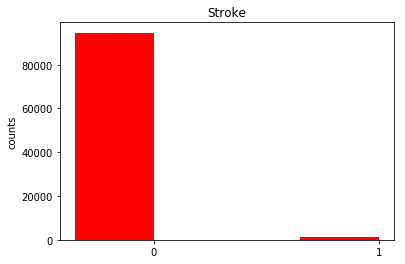

In [17]:
responses = df_combined_converted.groupBy("stroke").count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color="r")
 
plt.ylabel("counts")
plt.title("Stroke")
plt.xticks(ind + width/2., categories)

In [18]:
cp=df_combined_converted
X = cp.toPandas().filter(items=['gender', 'age', 'diabetes','hypertension','heart disease','smoking history','BMI'])
Y = cp.toPandas().filter(items=['stroke'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))
dataframe_1 = pd.DataFrame(x_train_res,columns=['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['stroke'])
# frames = [dataframe_1, dataframe_2]
result = dataframe_1.combine_first(dataframe_2)
imputeDF_1 = spark.createDataFrame(result)

C:\Users\achra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({0: 85150, 1: 85150})


([<matplotlib.axis.XTick at 0x2613498bc18>,
 <a list of 2 Text xticklabel objects>)

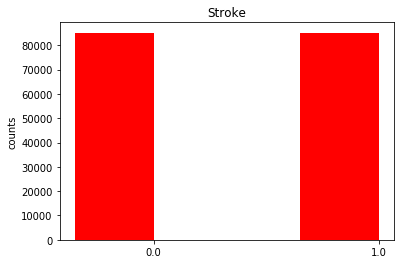

In [19]:
responses = imputeDF_1.groupBy("stroke").count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color="r")
 
plt.ylabel("counts")
plt.title("Stroke")
plt.xticks(ind + width/2., categories)

# Construction d'un pipline spark

In [20]:
binarizer = Binarizer(threshold=0.0, inputCol="stroke", outputCol="label")
binarizedDF = binarizer.transform(imputeDF_1)
binarizedDF = binarizedDF.drop("stroke")

In [21]:
featureColumns = ["gender","age","diabetes","hypertension",
 "heart disease","smoking history","BMI"]

assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")
assembled = assembler.transform(binarizedDF)
print(assembled)

DataFrame[BMI: double, age: double, diabetes: double, gender: double, heart disease: double, hypertension: double, smoking history: double, label: double, features: vector]


# Spliting de notre datset

In [24]:
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed=0)
print("Distribution of Ones and Zeros in trainingData is: ", trainingData.groupBy("label").count().take(3))

Distribution of Ones and Zeros in trainingData is:  [Row(label=0.0, count=59729), Row(label=1.0, count=59604)]


In [25]:
pd.DataFrame(trainingData.take(5),columns=trainingData.columns)

,BMI,age,diabetes,gender,heart disease,hypertension,smoking history,label,features
0,10.01,80.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 10.01)"
1,10.08,38.0,0.0,1.0,0.0,0.0,0.0,0.0,"(1.0, 38.0, 0.0, 0.0, 0.0, 0.0, 10.08)"
2,10.40,3.0,0.0,1.0,0.0,0.0,0.0,0.0,"(1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 10.4)"
3,10.60,7.0,0.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 10.6)"
4,10.77,12.0,0.0,1.0,0.0,0.0,0.0,0.0,"(1.0, 12.0, 0.0, 0.0, 0.0, 0.0, 10.77)"


# Training

In [26]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

# Prédiction et test

In [27]:
predictions = model.transform(testData)
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

Test Data Aread under ROC score is :  0.9809970449158908
